# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import option
from frontfixing import nielsen, company
import lcp

plt.style.use('ggplot')

K = 1
T = 1
put = option.put(K, T)
r = 0.1
sigma = 0.2
delta = 0.03
S_max = 2
S_min = 0
S_test = np.arange(S_min, S_max, step=0.2)

def plot_space_convergence(title, dx, V_pred):
    error = []
    for i in range(len(dx)-1):
        error.append(np.linalg.norm(V_pred[i+1][::2]-V_pred[i], ord=np.inf))
    log_error = np.log(error)
    log_dx = np.log(dx[:-1])
    p = np.polyfit(log_dx, log_error, deg=1)
    f = np.poly1d(p)
    log_dx_axis = np.linspace(np.min(log_dx), np.max(log_dx))
    plt.title(title)
    plt.scatter(log_dx, np.log(error), marker='x', color='black')
    plt.plot(log_dx_axis, f(log_dx_axis), '--k', linewidth=1)
    plt.ylabel("log error")
    plt.xlabel("log dx")
    text = plt.annotate(f"{p[0]:.2}x {'-' if p[1] <= 0 else '+'} {np.abs(p[1]):.2}", # this is the text
                (log_dx[1],log_error[1]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') 
    text.set_rotation(22)

def plot_time_convergence(title, dt, V_pred):
    error = []
    for i in range(len(dt)-1):
        error.append(np.linalg.norm(V_pred[i+1]-V_pred[i], ord=np.inf))
    log_error = np.log(error)
    log_dt = np.log(dt[:-1])
    plt.scatter(log_dt, np.log(error), marker='x', color='black')
    p = np.polyfit(log_dt, log_error, deg=1)
    f = np.poly1d(p)
    log_dt_axis = np.linspace(np.min(log_dt), np.max(log_dt))
    plt.title(title)
    plt.plot(log_dt_axis, f(log_dt_axis), '--k', linewidth=1)
    plt.ylabel("log error")
    plt.xlabel("log dt")
    text = plt.annotate(f"{p[0]:.2}x {'-' if p[1] <= 0 else '+'} {np.abs(p[1]):.2}", # this is the text
                (log_dt[1],log_error[1]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') 
    text.set_rotation(22)

def space_convergence_analysis(method, dx, dt, **kwargs):
    V_pred = []
    for _, dx_i in enumerate(dx):
        res = method(dx=dx_i, dt=dt, **kwargs)
        V_pred.append(res[1][:])
    return V_pred

def time_convergence_analysis(method, dx, dt, **kwargs):
    V_pred = []
    for i, dt_i in enumerate(dt):
        res = method(dx=dx, dt=dt_i, **kwargs)
        V_pred.append(res[1][:])
    return V_pred

# Front fixing method

## Nielsen transformation

### Explicit


##### Space

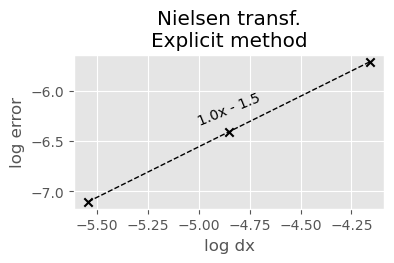

In [2]:
dx = np.array([1/64, 1/128, 1/256, 1/512])
dt = 0.5*dx[-1]**2
V_pred = space_convergence_analysis(nielsen.solve_explicitly, dx, dt, option=put, r=r, sigma=sigma, x_max=2, delta=delta)
plt.figure(figsize=(4,2))
plot_space_convergence("Nielsen transf.\nExplicit method", dx, V_pred)

##### Time

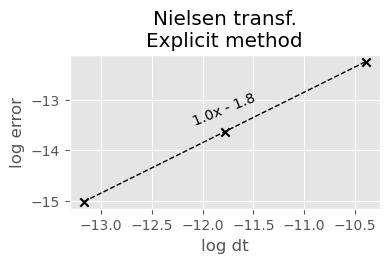

In [3]:
dx = 1/128
dt = 0.5*np.power([1/128, 1/256, 1/512, 1/1024],2)
V_pred = time_convergence_analysis(nielsen.solve_explicitly, dx, dt, option =put, r=r, sigma=sigma, x_max=3,delta=delta)
plt.figure(figsize=(4,2))
plot_time_convergence("Nielsen transf.\nExplicit method", dt, V_pred)

### Implicit

#### Space

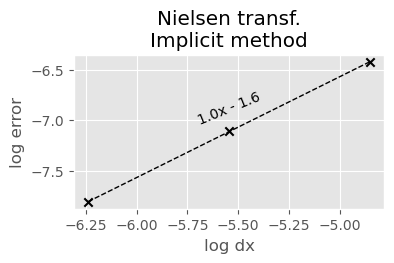

In [4]:
dx = [1/128, 1/256, 1/512, 1/1024]
dt = 1/1024
V_pred = space_convergence_analysis(nielsen.solve_implicitly, dx, dt, option=put, r=r, sigma=sigma, x_max=2, delta=delta, tolerance=1e-21, maxiter=10*6)
plt.figure(figsize=(4,2))
plot_space_convergence("Nielsen transf.\nImplicit method", dx, V_pred)

#### Time

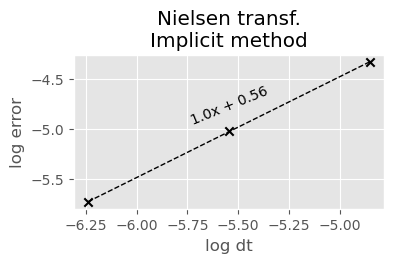

In [5]:
dx = 1/32
dt = [1/128, 1/256, 1/512, 1/1024]
V_pred = time_convergence_analysis(nielsen.solve_implicitly, dx, dt, option =put, r=r, sigma=sigma, x_max=2, delta=delta, tolerance=1e-21)
plt.figure(figsize=(4,2))
plot_time_convergence("Nielsen transf.\nImplicit method", dt, V_pred)

## Company transformation

### Explicit

#### Space

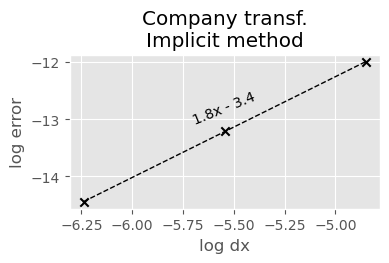

In [6]:
dx = [1/128, 1/256, 1/512, 1/1024]
dt = 0.5*dx[-1]**2
V_pred = space_convergence_analysis(company.solve_explicitly, dx, dt, option=put, r=r, sigma=sigma, x_max=2, delta=delta)
plt.figure(figsize=(4,2))
plot_space_convergence("Company transf.\nImplicit method", dx, V_pred)

#### Time

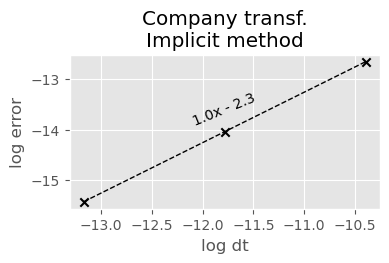

In [7]:
dx = 1/128
dt = 0.5*np.array([1/128, 1/256, 1/512, 1/1024])**2
V_pred = time_convergence_analysis(nielsen.solve_explicitly, dx, dt, option=put, r=r, sigma=sigma, x_max=3)
plt.figure(figsize=(4,2))
plot_time_convergence("Company transf.\nImplicit method", dt, V_pred)

# LCP + PSOR

## Explicit

### Space

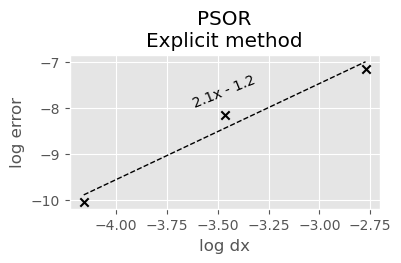

In [8]:
dx = [1/16, 1/32, 1/64, 1/128]
dt = 0.5*dx[-1]**2
V_pred = space_convergence_analysis(lcp.solve, dx, dt, option=put, r=r, sigma=sigma, x_max=2, delta=delta, theta=0)
plt.figure(figsize=(4,2))
plot_space_convergence("PSOR\nExplicit method", dx, V_pred)

#### Time

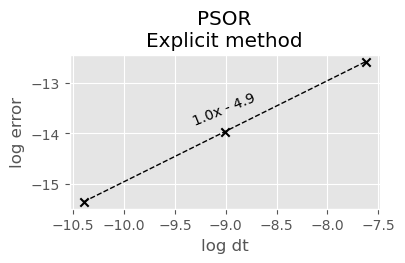

In [14]:
dx = 1/32
dt = 0.5*np.array([1/32, 1/64, 1/128, 1/256])**2
V_pred = time_convergence_analysis(lcp.solve, dx, dt, option=put, r=r, sigma=sigma, theta=0, delta=delta)
plt.figure(figsize=(4,2))
plot_time_convergence("PSOR\nExplicit method", dt, V_pred)

## Implicit

#### Space

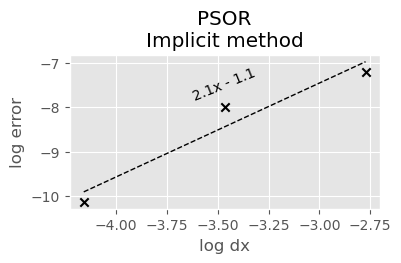

In [15]:
dx = [1/16, 1/32, 1/64, 1/128]
dt = 1/4
V_pred = space_convergence_analysis(lcp.solve, dx, dt, option=put, r=r, sigma=sigma, x_max=2, delta=delta, theta=1)
plt.figure(figsize=(4,2))
plot_space_convergence("PSOR\nImplicit method", dx, V_pred)

#### Time

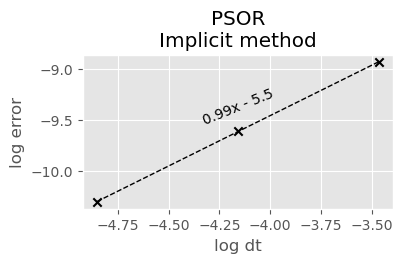

In [16]:
dx = 1/16
dt = [1/32, 1/64, 1/128, 1/256]
V_pred = time_convergence_analysis(lcp.solve, dx, dt, option=put, r=r, sigma=sigma, theta=1, delta=delta)
plt.figure(figsize=(4,2))
plot_time_convergence("PSOR\nImplicit method", dt, V_pred)

## Crank nicholson

#### Space

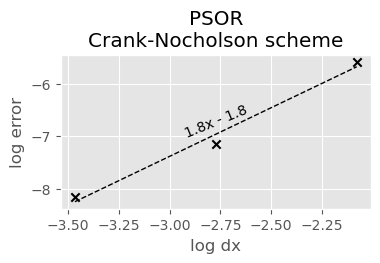

In [17]:
dx = [1/8, 1/16, 1/32, 1/64]
dt = 1/64
V_pred = space_convergence_analysis(lcp.solve, dx, dt, option=put, r=r, sigma=sigma, x_max=2, delta=delta, theta=.5)
plt.figure(figsize=(4,2))
plot_space_convergence("PSOR\nCrank-Nocholson scheme", dx, V_pred)

#### Time

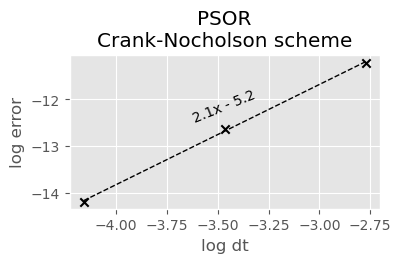

In [18]:
dx = 1/16
dt = [1/16, 1/32, 1/64, 1/128]
V_pred = time_convergence_analysis(lcp.solve, dx, dt, option=put, r=r, sigma=sigma, theta=.5, delta=delta)
plt.figure(figsize=(4,2))
plot_time_convergence("PSOR\nCrank-Nocholson scheme", dt, V_pred)